In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
import brainiak
import nilearn as nl
from nilearn import image, plotting, input_data

from scipy.spatial import distance

from utils import *

In [2]:
from sklearn.linear_model import LogisticRegression

classifier evidence over time for each subject / wedding
- train
- eval

In [3]:
def read_logfile(sub_num):
  """ 
  read psychopy logifle into dataframe
  """
  # initialize dataframe
  df = pd.DataFrame(columns=['tstamp','logtype','logdata'])
  # open logfile
  fpath = 'behav/silvy_buckets/sub1%iday2/%i_viewing.log'%(sub_num,sub_num)
  f = open(fpath, "r")
  # loop over logfile rows
  first_TR_bool = True
  for x in f:
    tstamp,B,C = x.split('\t')
    tstamp = float(tstamp)
    # correct tstamp relative to first TR
    if first_TR_bool and C == 'Keypress: equal\n':
      first_TR_bool = False
      first_TR_tstamp = tstamp
    df.loc[tstamp,'logtype'] = B[:-1]
    df.loc[tstamp,'logdata'] = C[:-1]
    df.loc[tstamp,'tstamp'] = tstamp
  return df,first_TR_tstamp

def reformat_index(df,first_TR_tstamp,TR_rate=1.5):
  """
  include TR column
  reset timestamps relative to first TR
  reindex by row number
  """
  # add TR column
  df['TR'] = int(0)
  # reindex relative to first TR
  df.index = df.index - first_TR_tstamp 
  # include TR column
  df.loc[:,'TR'] = np.floor(df.index /TR_rate).astype(int)
  # remove negative TRs
  df = df[df.TR >= 0 ]
  # reindex by row number 
  df.index = np.arange(len(df))
  return df
  
def include_state_column(df):
  """ 
  include column "state" which indicates which stimulus is being shown
  ** NB first and last wedding not included (10/12 weddings labeled)
  """
  df['state'] = np.nan
  vid_strL = ['vid1a','vid1b','vid2','vid3','vid4','vid5']
  for vid_str0,vid_str1 in zip(vid_strL[:-1],vid_strL[1:]):
    vid_start_idx = df[df.logdata == '%s: autoDraw = True'%vid_str0].index
    vid_end_idx = df[df.logdata == '%s: autoDraw = True'%vid_str1].index
    for trial_num in range(10):
      df.loc[vid_start_idx[trial_num]:vid_end_idx[trial_num],'state']=vid_str0
  return df

def include_wed_and_nors_columns(df):
  """ 
  at the beginning of each trial, psychopy preloads the videos that will be shown in that trial
  from the video .mp3 file names, I extract the wedding number and path
  from the path I infer north-or-south
  I then populate every row within that trial with these info
  ** NB last wedding not included (11/12 weddings labeled)
  """
  # North paths
  path1 = ['1a','1b','2a','3a','4a','5']
  path2 = ['1a','1b','2b','3b','4b','5']
  # South paths
  path3 = ['1a','1b','2a','3b','4a','5']
  path4 = ['1a','1b','2b','3a','4b','5']
  ## initialize columns
  df['wed'] = 99
  df['NorS'] = ''
  ## find rows corresponding to trial start (preloading videos)
  begin_trial_idxL = df[df.logdata.str[:len("Created vid1a = ")]=="Created vid1a = "].index
  ## loop over trials
  for begin_trial_idx,end_trial_idx in zip(begin_trial_idxL[:-1],begin_trial_idxL[1:]):
    ## extract rows containing preloading, and use .str operations to clean
    logdata_trial_info = df.iloc[begin_trial_idx:begin_trial_idx+6]
    logdata_trial_info = logdata_trial_info.logdata.str.split(',').str[5].str.split('/').str[1]
    ## further clean
    wed_int = int(logdata_trial_info.str.split('.').str[0].values[0].split('-')[1])
    path = logdata_trial_info.str.split('.').str[1].values
    ## decide NorS label based on path
    if np.array_equal(path,path1) or np.array_equal(path,path2):
      NorS_str = 'N'
    elif np.array_equal(path,path3) or np.array_equal(path,path4):
      NorS_str = 'S'
    else:
      assert False
    ## insert into dataframe
    df.loc[begin_trial_idx:end_trial_idx,'wed'] = wed_int
    df.loc[begin_trial_idx:end_trial_idx,'NorS'] = NorS_str
  return df

In [4]:
def load_logdf(sub_num):
  """ 
  wrapper for loading subject experiment timing info
  ** NB excludes first and last wedding
  """ 
  ## read psychopy log file into dataframe
  df,first_TR_tstamp = read_logfile(sub_num)
  ##
  df = reformat_index(df,first_TR_tstamp)
  ##
  df = include_state_column(df)
  ##
  df = include_wed_and_nors_columns(df)
  ## leave only TRs where wedding states are being shown
  df = df[df.state.notna()]
  return df

In [8]:
sub_num = 33
logdf = load_logdf(sub_num)


# load roi

In [13]:
def load_sub_roi(sub_num,task,roi_name):
  fpath = "sub-%i_task-%s_roi-%s.npy" %(sub_num,task,roi_name)
  return np.load('fmri_data/masked/'+fpath)

In [44]:
def get_xval_split_info(logdf):
  """
  returns 
    N_TR_train_L: TRs for training on North
    S_TR_train_L: TRs for training on South
    TR_test_L: TRs for testing
    label_test_L: label for testing TRs
  each is list len 10, containing the information for an iteration of xval 
  """
  ## hold out test wedding 
  wed_arr = logdf.wed.unique()
  wed_arr = wed_arr[wed_arr!=99]

  N_TR_train_L = []
  S_TR_train_L = []
  TR_test_L = []
  label_test_L = []
  
  for wed_num_test in wed_arr:
    ## training 
    # remove test wed from train_wed_arr
    wed_arr_train = wed_arr[wed_arr!=wed_num_test]
    # training subset of dataframe
    logdf_train = logdf[logdf.wed.isin(wed_arr_train)]
    # training TRs
    N_TR_train = logdf_train[logdf_train.NorS=='N'].TR.unique()
    S_TR_train = logdf_train[logdf_train.NorS=='S'].TR.unique()
    N_TR_train_L.append(N_TR_train)
    S_TR_train_L.append(S_TR_train)
    ## testing TRs
    logdf_test = logdf[(logdf.wed == wed_num_test)]
    TR_test = logdf_test.TR.unique()
    label_test = logdf_test.NorS.unique() 
    TR_test_L.append(TR_test)
    label_test_L.append(label_test[0])
  return N_TR_train_L,S_TR_train_L,TR_test_L,label_test_L
  

In [60]:
ROI_NAME_L

['rsherlockAvg_fc_thr5_pmc',
 'rsherlockAvg_fc_thr5_mpfc',
 'rsherlockAvg_fc_thr5_lTPJ',
 'rsherlockAvg_fc_thr5_rTPJ',
 'rsherlockAvg_fc_thr5_lSFG',
 'rsherlockAvg_fc_thr5_rSFG',
 'rhippocampusL_AAL',
 'rhippocampusR_AAL',
 'rhippocampusAAL']

In [81]:
""" 
CLASSIFIER CROSS VALIDATION
"""

fdir = 'fmri_data/xval/sweep1/'
task = 'videos'
roi_name = 'rsherlockAvg_fc_thr5_pmc'

for roi_name in ROI_NAME_L
accL = []
for sub_num in SUB_NS:
  roi_act = load_sub_roi(sub_num,task,roi_name)
  sub_accL = []
  ## xval split
  for N_TR_train,S_TR_train,TR_test,label_test in zip(*get_xval_split_info(logdf)):
    # split roi act into train and test
    roi_act_N_train = roi_act[N_TR_train,:]
    roi_act_S_train = roi_act[S_TR_train,:]
    roi_act_test = roi_act[TR_test,:]
    # form classifier datasets
    X_train = np.concatenate([roi_act_N_train,roi_act_S_train])
    X_test = roi_act_test
    Y_train = np.concatenate([np.ones(len(roi_act_N_train)),np.zeros(len(roi_act_S_train))])
    Y_test = np.repeat(int(label_test == 'N'),len(X_test))
    clf = sklearn.linear_model.LogisticRegression(solver='liblinear').fit(X_train,Y_train)
    sub_accL.append(clf.score(X_test,Y_test))
    yhat = clf.predict_proba(X_test)
    print(clf.score(X_test,Y_test),clf.score(X_train,Y_train))
  accL.append(sub_accL)

fpath = fdir+'acc-%s'%roi_name
np.save(fpath,np.array(accL))


(60, 2)
0.5666666666666667 1.0
(63, 2)
0.47619047619047616 1.0
(65, 2)
0.46153846153846156 1.0
(64, 2)
0.546875 1.0
(66, 2)
0.45454545454545453 1.0
(66, 2)
0.5 1.0
(67, 2)
0.5074626865671642 1.0
(66, 2)
0.4393939393939394 1.0
(66, 2)
0.5151515151515151 1.0
(67, 2)
0.4925373134328358 1.0


In [266]:
def mov_avg(X,w):
  A = np.ones(len(X)-w)
  for i in range(len(X)-w):
    A[i] = X[i:i+w].mean()
  return A

In [273]:
yhat_pr = clf.predict_proba(roi_act)[:,1]
yhat_plt = mov_avg(yhat_pr,30)

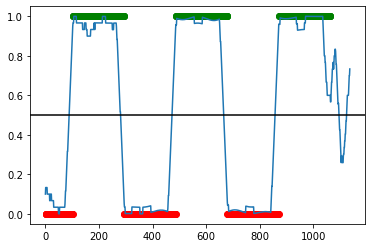

In [276]:
plt.plot(yhat_plt)
plt.scatter(NTR,np.ones(len(NTR)),c='g')
plt.scatter(STR,np.zeros(len(STR)),c='r')
plt.axhline(0.5,c='k')